In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# PLOTTING
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils

# SCIKIT
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

In [3]:
from datasetFromFile import MidiSavedDataset
midi_train_dataset = MidiSavedDataset(data_type = "train")
midi_val_dataset   = MidiSavedDataset(data_type = "val")

In [31]:
len(midi_train_dataset)

1000

In [4]:
n_train = len(midi_train_dataset)

X_train_list  = []
Y_train_list = []
for i in range(n_train): 
    data, labels = midi_train_dataset[i]
    X_train_list.append(np.transpose(data))
    Y_train_list.append(np.transpose(labels))

In [5]:
X_train = np.vstack(X_train_list)
Y_train = np.vstack(Y_train_list)

In [6]:
print(X_train.shape)
print(Y_train.shape)

(50000, 384)
(50000, 128)


In [7]:
n_val = len(midi_val_dataset)

X_val_list  = []
Y_val_list  = []
for i in range(n_val): 
    data, labels = midi_val_dataset[i]
    X_val_list.append(np.transpose(data))
    Y_val_list.append(np.transpose(labels))

In [8]:
X_val = np.vstack(X_val_list)
Y_val = np.vstack(Y_val_list)

In [9]:
print(X_val.shape)
print(Y_val.shape)

(6250, 384)
(6250, 128)


In [10]:
Y_output = np.argwhere(Y_train>0)
Y_train_mod = np.zeros(Y_train.shape[0])
Y_train_mod.fill(-1) # -1 means no note played

for element in Y_output: 
    Y_train_mod[element[0]] = element[1] # for a given timestamp, the last note listed in y_output will be kept
    

In [107]:
print(Y_train_mod)

[38. 38. 38. ... 41. 41. 41.]


In [132]:
def evaluate_metrics(preds, labels): 
    num_notes = 128
    correct = 0.0
    total = 0.0
    num_true_pos_label  = 0.0
    num_false_pos_label = 0.0
    num_pos_pred  = 0.0
    num_true_neg_label  = 0.0
    num_false_neg_label = 0.0
    num_neg_pred  = 0.0

    num_timesteps = preds.shape[0]
    
    for i in range(num_timesteps): 
        if (labels[i] == preds[i]):
            correct += 1.0
        total += 1.0

#     for i in range(num_timesteps): 
#         for j in range(num_notes):
#             if (labels[i,j] == 1.0):
#                 num_pos_pred += 1.0
#             else: 
#                 num_neg_pred += 1.0

#             if (preds[i,j] == labels[i,j]): 
#                 if (preds[i,j] == 1.0):
#                     num_true_pos_label += 1.0
#                 else: 
#                     num_true_neg_label += 1.0
#                 correct += 1.0
#             else: 
#                 if (preds[i,j] == 1.0): 
#                     num_false_pos_label += 1.0
#                 else: 
#                     num_false_neg_label += 1.0
#             total += 1.0
            
    accuracy = correct/total 
#     recall = num_true_pos_label / num_pos_pred
#     if (num_true_pos_label == 0 and num_false_pos_label == 0): 
#         precision = 1
#     else: 
#         precision = num_true_pos_label/ (num_true_pos_label + num_false_pos_label)
    
    print("Correct: ", correct, ", Num pos: ", num_pos_pred, "num true pos: ", num_true_pos_label, "num false pos: ", num_false_pos_label, ", accuracy: ", accuracy, ", recall: ", recall, ", precision: ", precision)
    return accuracy, recall, precision

In [32]:
start_index = 0
end_index = 50000

### SVM

In [137]:
# training a linear SVM classifier 
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', gamma = 'auto', class_weight = {-1:0.00001}, verbose = True)
# svclassifier = SVC(decision_function_shape='ovo', gamma='auto', verbose = True)

svclassifier.fit(X_train[start_index:end_index,:], Y_train_mod[start_index:end_index])

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight={-1: 1e-05}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [140]:
Y_pred = svclassifier.predict(X_val)

In [77]:
print(Y_val.shape)

(6250, 128)


In [139]:
print(Y_pred)

[34. 42. 42. ... 41. 41. 41.]


In [141]:
Y_pred_array = np.zeros_like(Y_val)

n = Y_pred.shape[0]
for i in range(n): 
    Y_pred_array[i, int(Y_pred[i])] = 1
   

In [51]:
time = np.arange(6250)

In [105]:
all_zeros = np.zeros_like(Y_pred_array)

all_zeros.fill(-1)


In [122]:
print(np.argmax(Y_val, axis=1))

[36 36 36 ... 29 29 29]


In [133]:
accuracy, recall, precision = evaluate_metrics(Y_pred, np.argmax(Y_val, axis=1))

Correct:  645.0 , Num pos:  0.0 num true pos:  0.0 num false pos:  0.0 , accuracy:  0.1032 , recall:  0.11044520547945205 , precision:  0.1032


In [131]:
accuracy, recall, precision = evaluate_metrics(Y_pred_array, Y_val)

Correct:  789200.0 , Num pos:  5840.0 num true pos:  645.0 num false pos:  5605.0 , accuracy:  0.9865 , recall:  0.11044520547945205 , precision:  0.1032


In [142]:
from sklearn.metrics import classification_report 

print(classification_report(np.argmax(Y_val, axis=1), Y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       410
        29.0       0.00      0.00      0.00       895
        31.0       0.00      0.00      0.00       720
        34.0       0.00      0.00      0.00         0
        36.0       0.00      0.00      0.00      1670
        37.0       0.00      0.00      0.00         0
        38.0       0.00      0.00      0.00       985
        39.0       0.00      0.00      0.00         0
        40.0       0.00      0.00      0.00       250
        41.0       0.32      0.54      0.40      1320
        42.0       0.00      0.00      0.00         0

    accuracy                           0.11      6250
   macro avg       0.03      0.05      0.04      6250
weighted avg       0.07      0.11      0.08      6250



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Plot

In [27]:
def plot_data(x, y): 
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y, marker='_')
    plt.xlabel('Time (x0.01 s)')
    plt.ylabel('MIDI Pitch')
#     plt.ylim(top=384)
    plt.show()

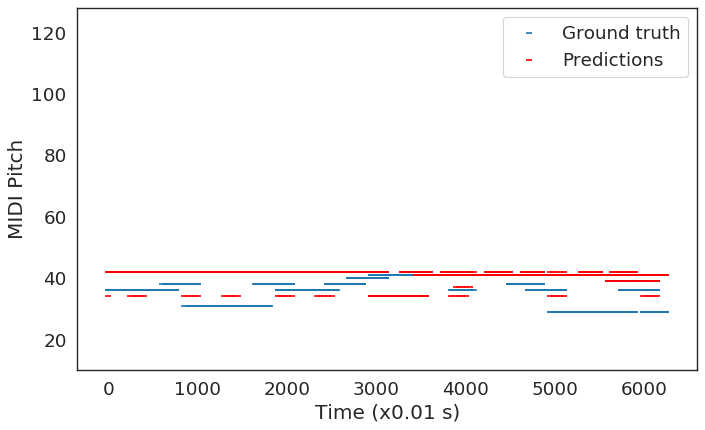

In [81]:
# output_X_train = np.argwhere(X_train>0)
# plot_data(output_X_train[:,0], output_X_train[:,1])

# output_Y_train = np.argwhere(Y_train>0)
# plot_data(output_Y_train[:,0], output_Y_train[:,1])

# output_X_val = np.argwhere(X_val>0)
# plot_data(output_X_val[:,0], output_X_val[:,1])

# output_Y_val = np.argwhere(Y_val>0)
# plot_data(output_Y_val[:,0], output_Y_val[:,1])


fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(output_Y_val[:,0], output_Y_val[:,1], marker='_', label='Ground truth')
plt.scatter(time[:], Y_pred[:], marker='_',color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=128)
plt.ylim(bottom=10)
plt.legend(loc='best')
plt.show()


# output_X_val = np.argwhere(X_val>0)
# plot_data(output_X_val[:,0], output_X_val[:,1])

# output_Y_val = np.argwhere(Y_val>0)
# plot_data(output_Y_val[:,0], output_Y_val[:,1])

# # output_Y_train = np.argwhere(Y_train[0:end_index]>0)
# # plot_data(output_Y_train[:,0], output_Y_train[:,1])

# output_Y_pred = np.argwhere(Y_pred_array>0)
# plot_data(output_Y_pred[:,0], output_Y_pred[:,1])

(6250,)


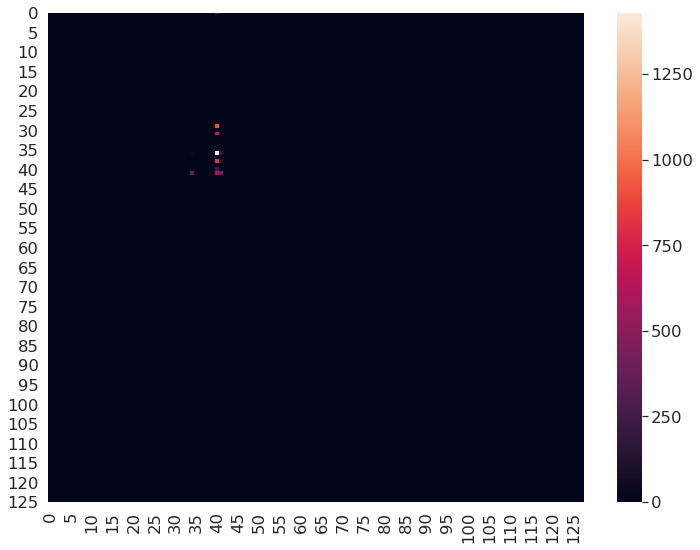

In [136]:
print(np.argmax(Y_val, axis=1).shape)

from sklearn.metrics import confusion_matrix
import seaborn as sn 

cm = confusion_matrix(np.argmax(Y_val, axis=1), Y_pred, labels=np.arange(128))
plt.figure(figsize=(12, 9))
sn.heatmap(cm)

### Logistic Regression

In [131]:
from sklearn.linear_model import LogisticRegression
clf_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 1000).fit(X_train, Y_train_mod)


In [132]:
Y_pred_reg = clf_reg.predict(X_val)

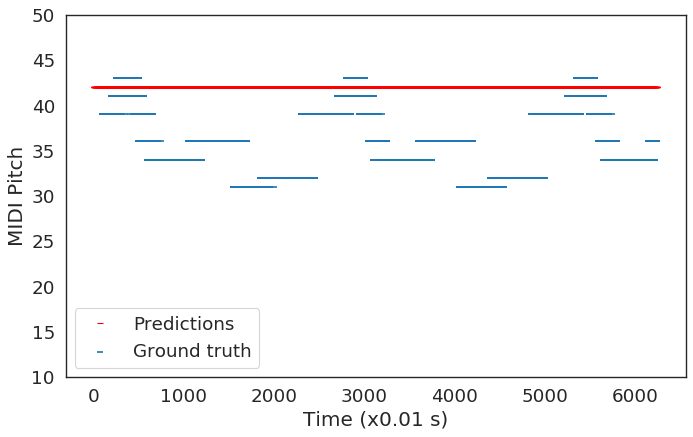

In [156]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
output_y_test = np.argwhere(Y_val>0)
plt.scatter(output_y_test[:,0], output_y_test[:,1], marker='_', label='Ground truth')
plt.plot(Y_pred[:], '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()

In [134]:
y_pred_reg_train = clf_reg.predict(X_train)


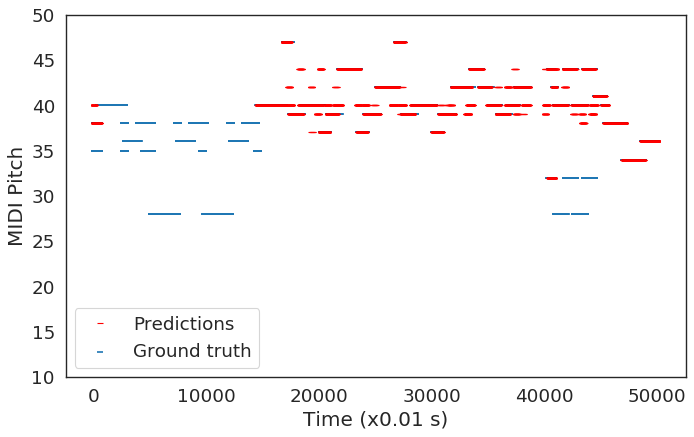

In [139]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
output_y_train = np.argwhere(Y_train>0)
plt.scatter(output_y_train[:,0], output_y_train[:,1], marker='_', label='Ground truth')
plt.plot(y_pred_reg_train, '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()